# Exploration of the Ford-go bike share system for February 2019
## by Christine Shuttleworth

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The data comprises all data points for February 2019.

In [110]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
import math
from geopy import Point
from geopy.distance import distance

%matplotlib inline

pd.options.display.max_rows=100

df_bike_raw = pd.read_csv('../Data/201902-fordgobike-tripdata.csv')


### Assessing data and cleaning data

In [111]:
df_bike_raw.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [112]:
df_bike_raw.shape

(183412, 16)

In [113]:
df_bike_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [114]:
type(df_bike_raw.start_time[0])

str

In [115]:
df_bike_raw.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


In [116]:
print(df_bike_raw.user_type.unique())
print(df_bike_raw.member_gender.unique())
print(df_bike_raw.bike_share_for_all_trip.unique())

['Customer' 'Subscriber']
['Male' nan 'Other' 'Female']
['No' 'Yes']


#### Assessment: 
The data table is set up as a clean data table. No variables are stored incorrectly or twice.
- Issue: Missing data points in the station_name and station_id. Lat and Long are given. Investigate if these points can be filled in from other information.
- Issue: start_time and end_time are str format -> convert to dateimt
- Issue: Station id should be an integer
- Issue: User Type and Member gender should be categorical
- Issue: Member birth year should be a datetime (year) or a string (will try year first)
- Issue: Bikeshare for all trip should be Boolean
- Issue: Bike ID could be a string

- Issue: max longitude is quite a way outside San Franzisco - need to plot outliers
- Issue: min longitude is in San Jose. Is this still in the greater San Franzikso bay area?
- Issue: max duraction_sec is about 23 hours - check value
- Issue: min duration_sec is about 1 min - check value
- Issue: min member_birth_year = 1878 - check values

#### Cleaning

In [117]:
## Issue: Missing data points in the station_name and station_id. Lat and Long are given. Investigate if these points can be filled in from other information.

df_nan_stations = df_bike_raw.loc[df_bike_raw.start_station_id.isnull()]
nan_stations = df_nan_stations.groupby(['start_station_latitude','start_station_longitude']).size().reset_index(name='station_count')

#for i in range(0,nan_stations.shape[0]):
#   print(df_bike_raw.query(f'start_station_latitude ==  {nan_stations.start_station_latitude[i]} and start_station_longitude == {nan_stations.start_station_longitude[i]}').start_station_name)
    
## None of th stations have station_id or station_name. So the data was not missed when inputing, it just does not exists for these stations.

In [118]:
# Issue: start_time and end_time are str format
# Issue: Member birth year should be a year 
df_bike_raw['start_time'] =  pd.to_datetime(df_bike_raw['start_time'])
df_bike_raw['end_time'] = pd.to_datetime(df_bike_raw['end_time'])
df_bike_raw['duration'] = df_bike_raw['end_time'] - df_bike_raw['start_time']
                                     
df_bike_raw['member_birth_year'] = pd.to_datetime(df_bike_raw['member_birth_year'], format='%Y')
df_bike_raw.head()
#df_bike.info()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984-01-01,Male,No,14:29:45.830000
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaT,NaN,No,11:48:41.267000
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972-01-01,Male,No,17:10:54.928000
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989-01-01,Other,No,10:08:10.832000
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974-01-01,Male,Yes,00:26:25.525000


In [119]:
# Issue: Station id should be an integer
# Issue: User Type and Member gender should be categorical
# Issue: Member birth year should be a year
# Issue: Bikeshare for all trip should be Boolean
# Issue: Bike ID could be a string
# There is no station_id that is 0, therefore 0 is used for missing data values

df_bike_raw.start_station_id.fillna(value=0, inplace=True) 
df_bike_raw.end_station_id.fillna(value=0, inplace=True)

df_bike_raw = df_bike_raw.astype({'start_station_id':'int64', 'end_station_id':'int64', 'bike_id':'str','member_gender':'category', 'user_type':'category'})

In [120]:
df_bike_raw['bike_share_for_all_trip'] = df_bike_raw.bike_share_for_all_trip.replace({'Yes': True,'No': False })

In [121]:
df_bike_raw.info()
df_bike_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   duration_sec             183412 non-null  int64          
 1   start_time               183412 non-null  datetime64[ns] 
 2   end_time                 183412 non-null  datetime64[ns] 
 3   start_station_id         183412 non-null  int64          
 4   start_station_name       183215 non-null  object         
 5   start_station_latitude   183412 non-null  float64        
 6   start_station_longitude  183412 non-null  float64        
 7   end_station_id           183412 non-null  int64          
 8   end_station_name         183215 non-null  object         
 9   end_station_latitude     183412 non-null  float64        
 10  end_station_longitude    183412 non-null  float64        
 11  bike_id                  183412 non-null  object         
 12  us

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984-01-01,Male,False,14:29:45.830000
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23,The Embarcadero at Steuart St,37.791464,-122.391034,81,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaT,NaN,False,11:48:41.267000
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972-01-01,Male,False,17:10:54.928000
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989-01-01,Other,False,10:08:10.832000
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974-01-01,Male,True,00:26:25.525000


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
92,1940,2019-02-28 22:42:29.789,2019-02-28 23:14:50.351,377,Fell St at Stanyan St,37.771917,-122.453704,50,2nd St at Townsend St,37.780526,-122.390288,4424,Subscriber,1987-01-01,Female,False,00:32:20.562000
196,1520,2019-02-28 22:10:44.680,2019-02-28 22:36:05.108,377,Fell St at Stanyan St,37.771917,-122.453704,126,Esprit Park,37.761634,-122.390648,5229,Subscriber,1987-01-01,Male,False,00:25:20.428000
771,847,2019-02-28 20:19:56.880,2019-02-28 20:34:04.433,377,Fell St at Stanyan St,37.771917,-122.453704,58,Market St at 10th St,37.776619,-122.417385,5867,Subscriber,1999-01-01,Male,False,00:14:07.553000
1228,244,2019-02-28 19:32:25.055,2019-02-28 19:36:29.607,377,Fell St at Stanyan St,37.771917,-122.453704,70,Central Ave at Fell St,37.773311,-122.444293,4407,Subscriber,1986-01-01,Male,False,00:04:04.552000
1451,1378,2019-02-28 18:52:01.967,2019-02-28 19:14:59.970,377,Fell St at Stanyan St,37.771917,-122.453704,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,5133,Subscriber,1984-01-01,Female,False,00:22:58.003000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182645,1453,2019-02-01 07:44:18.191,2019-02-01 08:08:31.606,377,Fell St at Stanyan St,37.771917,-122.453704,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,5315,Subscriber,NaT,NaN,False,00:24:13.415000
182726,648,2019-02-01 07:50:42.229,2019-02-01 08:01:30.845,377,Fell St at Stanyan St,37.771917,-122.453704,56,Koshland Park,37.773414,-122.427317,5063,Subscriber,1985-01-01,Female,False,00:10:48.616000
182838,1634,2019-02-01 07:24:08.481,2019-02-01 07:51:22.662,377,Fell St at Stanyan St,37.771917,-122.453704,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,1228,Subscriber,1983-01-01,Male,False,00:27:14.181000
182980,953,2019-02-01 07:17:38.537,2019-02-01 07:33:32.186,377,Fell St at Stanyan St,37.771917,-122.453704,110,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,4597,Subscriber,1990-01-01,Female,False,00:15:53.649000


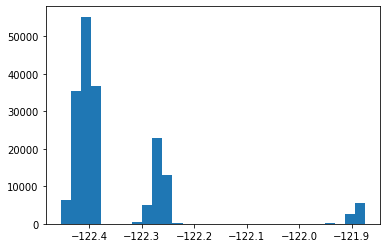

In [122]:
## Issue: max longitude is quite a way outside San Franzisco - need to plot outliers
## Issue: min longitude is in San Jose. Is this still in the greater San Franzikso bay area?
plt.hist(data=df_bike_raw, x = 'start_station_longitude', bins=30);
df_bike_raw.loc[df_bike_raw.start_station_longitude == df_bike_raw.start_station_longitude.max()]

## I think these points are valid points and belong to the greater San Francisco area. There is no mistake here.

df_bike_raw.loc[df_bike_raw.start_station_longitude == df_bike_raw.start_station_longitude.min()]

## The min is bang in the middle of San Francisco. Also no mistake.

TypeError: 'str' object is not callable

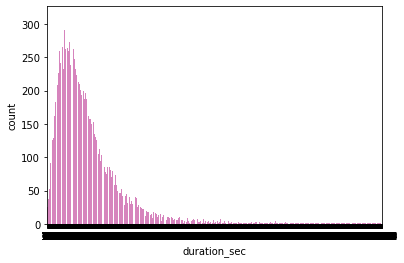

In [123]:
## Issue: max duraction_sec is about 23 hours - check value
## Issue: min duration_sec is about 1 min - check value
base_color = sb.color_palette()[6]
x_bins = np.arange(0,80000, 1000)
x_ticks = [60, 200, 1000, 3000, 10000, 30000, 80000]
#plt.hist(data=df_bike, x='duration_sec', bins = x_bins);
sb.countplot(data=df_bike_raw, x='duration_sec', color=base_color)
plt.xscale('log')
plt.xticks(x_ticks);

In [ ]:
df_bike_raw.loc[df_bike_raw.duration_sec == df_bike_raw.duration_sec.max()]
df_bike_raw.loc[df_bike_raw.duration_sec == df_bike_raw.duration_sec.min()]

#df_bike.loc[df_bike.duration_sec > 80000]
###The min and max values are possible and have been recorded as such. There are no errors here but quite a few outliers.

In [ ]:
## Issue: min member_birth_year = 1878 - check values

df_bike_raw.loc[df_bike_raw.member_birth_year == df_bike_raw.member_birth_year.min()]

#This is certainly an error. I will update the dataframe to set the birthyear to 1978, which is much more likely.
df_bike_raw['member_birth_year'] = df_bike_raw['member_birth_year'].mask(df_bike_raw['member_birth_year'].dt.year < 1900, 
                             df_bike_raw['member_birth_year'] + pd.offsets.DateOffset(years=100))

df_bike_raw.loc[df_bike_raw.member_birth_year == df_bike_raw.member_birth_year.min()]

In [ ]:
#plt.hist(data=df_bike, x='member_birth_year', bins=20);

## There is another spike around 1900. These birthdays were probably put in wrong. The users may not have wanted to give the birthday or they
## meant to select 2000. 

plt.hist (data=df_bike_raw.query('member_birth_year < 1940'), x='member_birth_year');

## I will set birthdays below 1920 to Null values. As they are most likely wrongly input. Not sure how many 100 year old are still cycling in San Francisco!

df_bike_raw['member_birth_year'].loc[df_bike_raw['member_birth_year'].dt.year <= 1920] = np.nan

In [ ]:
plt.hist (data=df_bike_raw.query('member_birth_year < 1940'), x='member_birth_year');

In [ ]:
df_bike_raw.query('member_birth_year < 1930')

### Adding extra column: Distance_km

The dataset has been cleaned. Now I would like to add another column that contains the distance between the start_station and the end_station. Having the starting Lat/Long and End Lat/Long, I can calculate this.

In [ ]:
##Creating two new columns with geopy that depict the start and end point of the journey

df_bike_raw['start_point'] = df_bike.apply(lambda row: Point(latitude=row['start_station_latitude'], longitude=row['start_station_longitude']), axis=1)
df_bike_raw['end_point'] = df_bike.apply(lambda row: Point(latitude=row['end_station_latitude'], longitude=row['end_station_longitude']), axis=1)

In [ ]:
df_bike_raw.head()

In [ ]:
## Calculate the distance between the two points

df_bike_raw['distance_km'] = df_bike_raw.apply(lambda row: distance(row['start_point'], row['end_point']).km , axis=1)


In [ ]:
df_bike_raw.head()

In [ ]:
median_lat = df_bike_raw.start_station_latitude.median()
bins_lat=[0, median_lat, median_lat*2]
bins_lat


### Adding extra column: start_point_quadrant - NE; NW, SE, SW

In [ ]:
##Create lat and long bins to sort start station into and convert lat and long into a categorical value
median_lat = df_bike_raw.start_station_latitude.median()
lat_min = df_bike_raw.start_station_latitude.min()
lat_max = df_bike_raw.start_station_latitude.max()

bins_lat=[lat_min-1, median_lat, lat_max +1]
labels_lat = ['S', 'N']

median_long = df_bike_raw.start_station_longitude.median()
long_min = df_bike_raw.start_station_longitude.min()
long_max = df_bike_raw.start_station_longitude.max()
bins_long=[long_min-1,median_long, long_max+1]
labels_long = ['E', 'W']
          
start_point_quadrant_lat = pd.cut(df_bike_raw.start_station_latitude, bins_lat, labels=labels_lat, include_lowest=True)
start_point_quadrant_long = pd.cut(df_bike_raw.start_station_longitude, bins_long, labels=labels_long, include_lowest=True)    

#start_point_quadrant_lat

df_bike_raw['start_point_quadrant'] = start_point_quadrant_lat.astype(str) + start_point_quadrant_long.astype(str)

#mean_price = diamonds.groupby(carat_bins).price


### Adding extra column: end_point_quadrant - NE; NW, SE, SW

In [ ]:
##Create lat and long bins to sort start station into and convert lat and long into a categorical value
median_lat = df_bike_raw.end_station_latitude.median()
lat_min = df_bike_raw.end_station_latitude.min()
lat_max = df_bike_raw.end_station_latitude.max()

bins_lat=[lat_min-1, median_lat, lat_max +1]
labels_lat = ['S', 'N']

median_long = df_bike_raw.end_station_longitude.median()
long_min = df_bike_raw.end_station_longitude.min()
long_max = df_bike_raw.end_station_longitude.max()
bins_long=[long_min-1,median_long, long_max+1]
labels_long = ['E', 'W']
          
end_point_quadrant_lat = pd.cut(df_bike_raw.end_station_latitude, bins_lat, labels=labels_lat, include_lowest=True)
end_point_quadrant_long = pd.cut(df_bike_raw.end_station_longitude, bins_long, labels=labels_long, include_lowest=True)    


df_bike_raw['end_point_quadrant'] = end_point_quadrant_lat.astype(str) + end_point_quadrant_long.astype(str)

## Need to refractor to create a funtion and read in column names


In [ ]:
df_bike_raw.head(2)

### What is the structure of your dataset?

The data consists of 20 variables and about 180 000 rows of data associated with the Ford bike share system in the Greater San Francisco area. The data includes:
- the start and end time of each trip, duration of the trip, 
- location of the start and end of the journey and the distance of the journey, 
- bike id and 
- information on the customer that used the bike. Ideally, there should be a separate customer table with the information of each user of the bike share system, but there is not enough information to create this. As it is, the users are kept anonymous. 
- Finally, there is data recording if the trip was completely covered by the bike share or if the distance cycled was only part of the trip.

This dataset contains some date_time variables, numeric variables, names, one boolean column and two categorical columns:

User Type:
- 'Customer'
- 'Subscriber'

Member Gender:
- 'Male'
- 'Female'
- 'Other'
- nan

### What is/are the main feature(s) of interest in your dataset?

My main interest is which variables predict the length (time or distance) of a bike share journey best. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect the length and distance of the trip change with the different user characteristics, e.g. type of user, gender, age. The length and distance may also be influenced by the location of the start and end points of the trips and the day of the week when the trip took place.

Having two variables that describe the journey - length and distance - I can compare how well they describe each other. Are shorter journeys in time also shorter in distance?

The start_time and end_time column of the bike share journeys, helps the investigation, when in Feb 2019 are most trips taken. During the week or weekend? Do these trends vary for the different user characteristics?

The station information is interesting, as I can use this to find out which stations are used most often to start longer or shorter journeys. Are there areas in the Greater San Francisco area 
where longer bike trips are taken than others? Does the average distance of the trips vary with the location of the start of the trip/end of the trip? For this I will try to plot the stations and/or categorise them into quadrats - that divide the greater San Francisco area into four parts, NW, NE, SE, SW. 


## Univariate Exploration

In this section, I will look at the two main numerical variables of interests: trip length and distance. To be able to find what influences the length and distance of a trip, I will also look the the categorical columns of user_type, customer_gender, 

In [ ]:
## copying cleaned dataset to a new dataframe

df_bike = df_bike_raw.copy()

In [84]:
df_bike.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,duration,distance_km
count,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412,183412.000000
mean,726.078435,138.441569,37.771223,-122.352664,136.102780,37.771427,-122.352250,0 days 00:12:06.577548,1.690555
std,1794.389780,111.811012,0.099581,0.117097,111.544544,0.099490,0.116673,0 days 00:29:54.388971,1.097158
min,61.000000,0.000000,37.317298,-122.453704,0.000000,37.317298,-122.453704,0 days 00:01:01.081000,0.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,0 days 00:05:25.428500,0.909777
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,0 days 00:08:34.649500,1.429907
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,0 days 00:13:16.317000,2.226169
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,0 days 23:44:04.830000,69.465977


#### Bike trip duration:

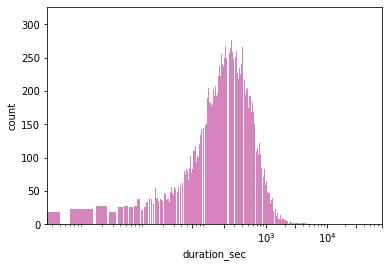

In [105]:
base_color = sb.color_palette()[6]
x_bins = 10 ** np.arange(50,86000, 5000)
x_ticks = [60, 200, 1000, 3000, 10000]
#plt.hist(data=df_bike, x='duration_sec', bins = x_bins);
sb.countplot(data=df_bike, x='duration_sec', color=base_color)
plt.xscale('log')
plt.xticks(x_ticks);

The distribution of the duration of the bike trips is unimodal with a spike between 100 and 200 seconds. The distribution is extremely skewed to the right with massive outliers. 75 % of the trips are shorter than 13:16 hours. It is unlikely that the trip on a bike within the San Francisco Bay area will take a whole day (max = 23h44min). I suspect the bike was rented and used for several trips or taken somewhere over night and returned it on the next day. I will keep these outliers in the data however, as the bike was unavailable for other users during this time. It does not matter if it was ridden or not. How much time was spend on the bike can be estimated, once I compare the distance with the trip length by e.g. calculating average speed. A low speed will indicate more time spend off the bike.

####  Bike trip distance:

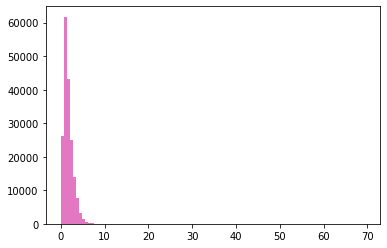

In [95]:
plt.hist(data=df_bike, x='distance_km', color=base_color, bins=100);

Just like the journey time, the distance is also very highly skewed to the right. I will add a log scale transformation and plot trips that are less than 10 km to see the detail of the distribution of the shorter trips.

TypeError: 'str' object is not callable

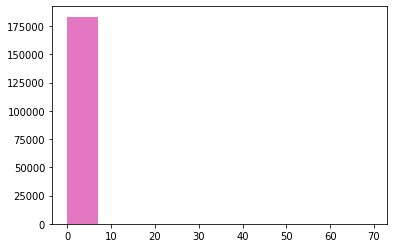

In [109]:
df_bike_sub = df_bike
plt.hist(data=df_bike, x='distance_km', color=base_color)
plt.xscale('log')
#plt.xticks(x_ticks);

In [97]:
# I looked up the maximum value on Google map and it looks like a valid trip. 
df_bike.query('distance_km > 68')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration,start_point,end_point,distance_km,start_point_quadrant,end_point_quadrant
112038,6945,2019-02-12 14:28:44.402,2019-02-12 16:24:30.158,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,300,Palm St at Willow St,37.317298,...,Subscriber,1985-01-01,Female,False,01:55:45.756000,"37 47m 22.6514s N, 122 24m 2.9196s W","37 19m 2.27244s N, 121 53m 5.982s W",69.465977,NE,SW


![Longest Trip](LongestTrip.png)

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python

https://pypi.org/project/geopy/

https://stackoverflow.com/questions/55909305/using-geopy-in-a-dataframe-to-get-distances

https://geopy.readthedocs.io/en/stable/#module-geopy.distance